# Probabilistic Forecasting: Conformal Regression

Conformal prediction is a framework for constructing prediction intervals that are valid with respect to the coverage probability. The interval is created by combining the predictions of a point-forecasting model with its residuals. These residuals help estimate the width of the prediction interval, which is then added to the point forecast. Skforecast implements [Split Conformal Prediction (SCP)](https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html#the-split-method).

Conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalInterval` transformer.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
There are several well-established <a href="https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html" target="_blank">methods for conformal prediction</a>, each with its own characteristics and assumptions. However, when applied to time series forecasting, their coverage guarantees are only valid for one-step-ahead predictions. For multi-step-ahead predictions, the coverage probability is not guaranteed. Skforecast implements Split Conformal Prediction (SCP) due to its simplicity and efficiency. 

</div>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

## Libraries and data

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Data
# ==============================================================================
data = fetch_dataset(name='ett_m2')
data = data[['OT']]
data.head(2)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 7)


,OT
date,
2016-07-01 00:00:00,38.661999
2016-07-01 00:15:00,38.223000


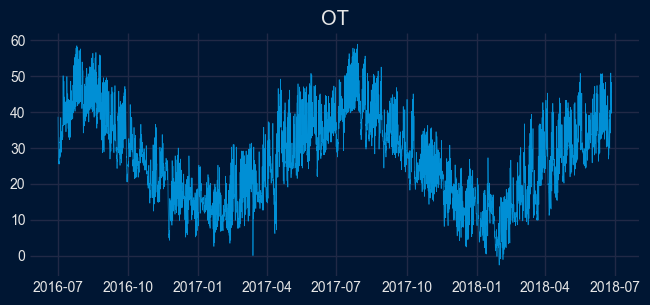

In [3]:
# Plot target time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data['OT'])
ax.set_title("OT");

In [4]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )
exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['OT']).tolist()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,
2016-07-01 00:00:00,38.661999,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:15:00,38.223000,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:30:00,37.344002,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0


In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-09-01 23:59:00'
end_validation = '2018-04-01 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 00:00:00 --- 2017-09-01 23:45:00  (n=41088)
Dates validacion : 2017-09-02 00:00:00 --- 2018-04-01 23:45:00  (n=20352)
Dates test       : 2018-04-02 00:00:00 --- 2018-06-26 19:45:00  (n=8240)


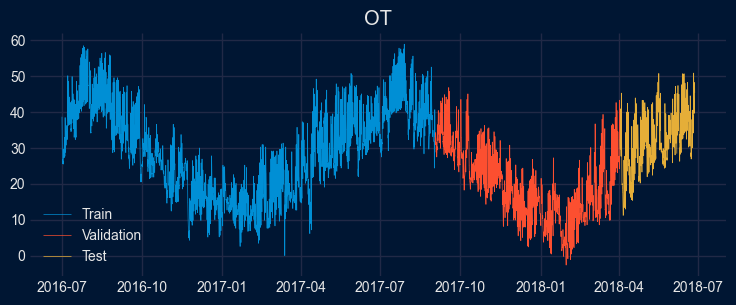

In [6]:
# Plot partitions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

## Calibration (Out-sample residuals)

To address the issue of overoptimistic intervals, it is recomended to use out-sample residuals. These are residuals from a validation set, also known as calibration set, which contains data not seen during training. These residuals can be obtained through backtesting.

In [7]:
# Create and fit forecaster
# ==============================================================================
params = {
    "max_depth": 4,
     "verbose": -1,
}
lags = [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73]
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=15926, **params),
                 lags            = lags,
                 window_features = window_features,
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'OT'],
    exog = data.loc[:end_validation, exog_features]
)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3 23 24 25 47 48 49 71 72 73] 
Window features: ['roll_mean_72'] 
Window size: 73 
Exogenous included: True 
Exogenous names: 
    day_of_week_cos, day_of_week_sin, hour_cos, hour_sin, month_cos, month_sin,
    week_cos, week_sin, year 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2016-07-01 00:00:00'), Timestamp('2018-04-01 23:45:00')] 
Training index type: DatetimeIndex 
Training index frequency: 15min 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 4,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-02-15 17:22:48 
Last fit date: 2025-02-15 17:22:49 
Skforecast version: 0.15.0 
Python version: 3.12.4 
Forecaster id: None

In [8]:
# Backtesting on validation/calibration data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_validation, 'OT'],
                         exog          = data.loc[:end_validation, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/848 [00:00<?, ?it/s]

negative    14131
positive     6221
Name: count, dtype: int64


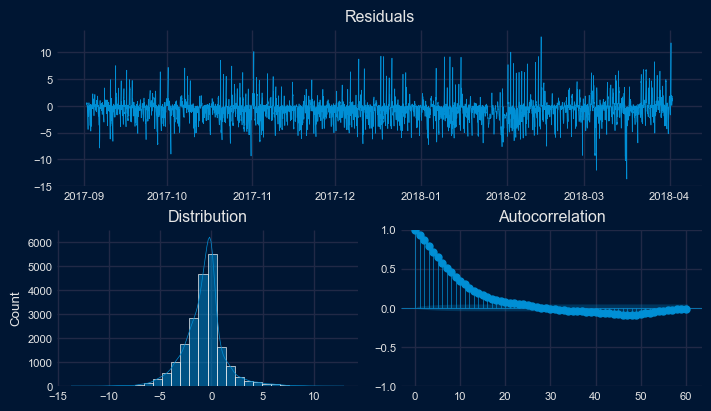

In [9]:
# Distribution of out-sample residuals
# ==============================================================================
residuals = data.loc[predictions_val.index, 'OT'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

With the `set_out_sample_residuals()` method, the out-sample residuals are stored in the forecaster object so that they can be used to calibrate the prediction intervals.

In [10]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

Now that the new residuals have been added to the forecaster, the prediction intervals can be calculated using `use_in_sample_residuals = False`.

In [11]:
# Prediction intervals
# ==============================================================================
forecaster.predict_interval(
    steps                   = 24,
    exog                    = data.loc[end_validation:, exog_features],
    interval                = [10, 90],
    method                  = 'conformal',
    use_in_sample_residuals = False
)

,pred,lower_bound,upper_bound
2018-04-02 00:00:00,32.024773,29.586857,34.462688
2018-04-02 00:15:00,31.853564,29.415649,34.291479
2018-04-02 00:30:00,31.695225,29.257309,34.133140
2018-04-02 00:45:00,31.442913,29.004998,33.880828
2018-04-02 01:00:00,31.390724,28.952809,33.828639
2018-04-02 01:15:00,31.137807,28.699892,33.575722
2018-04-02 01:30:00,30.926586,28.488671,33.364501
2018-04-02 01:45:00,30.793334,28.355419,33.231249
2018-04-02 02:00:00,30.544763,28.106848,32.982678
2018-04-02 02:15:00,30.544763,28.106848,32.982678


It is also possible to use forecast prediction intervals within a backtesting loop.

In [12]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'conformal',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions.head(5)

  0%|          | 0/344 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2018-04-02 00:00:00,32.024773,29.586857,34.462688
2018-04-02 00:15:00,31.853564,29.415649,34.291479
2018-04-02 00:30:00,31.695225,29.257309,34.133140
2018-04-02 00:45:00,31.442913,29.004998,33.880828
2018-04-02 01:00:00,31.390724,28.952809,33.828639


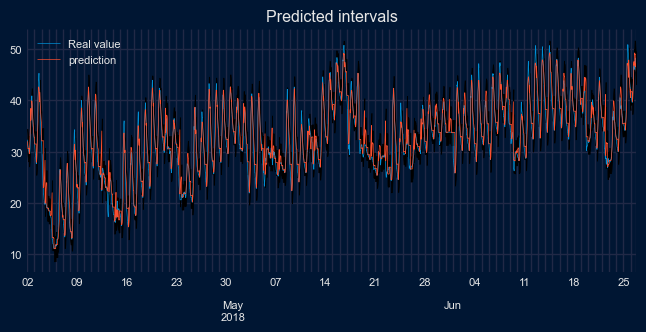

In [13]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "OT",
    title               = "Predicted intervals",
    kwargs_fill_between = {'color': 'black', 'zorder': 1}
)

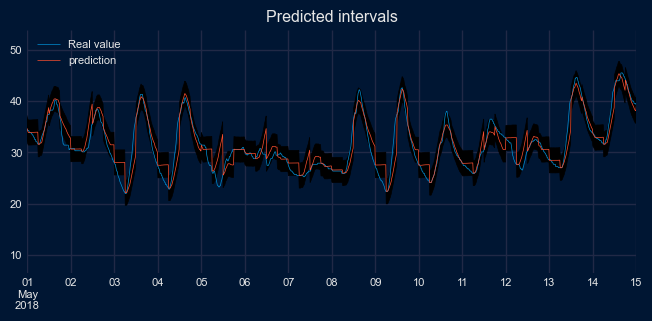

In [14]:
# Plot intervals with zoom ['2018-05-01', '2018-05-15']
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "OT",
    initial_x_zoom      = ['2018-05-01', '2018-05-15'],
    title               = "Predicted intervals",
    kwargs_fill_between = {'color': 'black', 'zorder': 1}
);

In [15]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'OT'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 80.93 %
Area of the interval: 40176.84


The prediction intervals generated using conformal prediction achieve an empirical coverage very close to the nominal coverage of 80%.